In [1]:
import numpy as  np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as st
import os
sns.set_style("darkgrid")

# Settare vuota questa variabile oppure impostare la prorpia cartella di lavoro
wdir = r"D:\Python\Casual\Machine_Learning\DataFoundamentalsProject\fundamentals"

In [2]:
df = pd.read_csv(os.path.join(wdir, "IRIS.csv"), engine="c")

# Analisi Esplorativa
---

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


Visualizzazione parziale del dataset giusto per farsi un'idea

In [4]:
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


Conversione della colonna "species" in category, per coerenza con il tipo di dato

In [5]:
df.species = df["species"].astype("category")

La colonna "species" rappresenta il target della classificazione, è utile capire quante classi occorre verificare

In [6]:
df.species.unique().tolist()

['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']

Descrizione generale del dataset

In [7]:
df.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


# Analisi Descrittiva
---

Numerosità di ogni classe:
* Si nota che per ogni classe la numerosità è la stessa

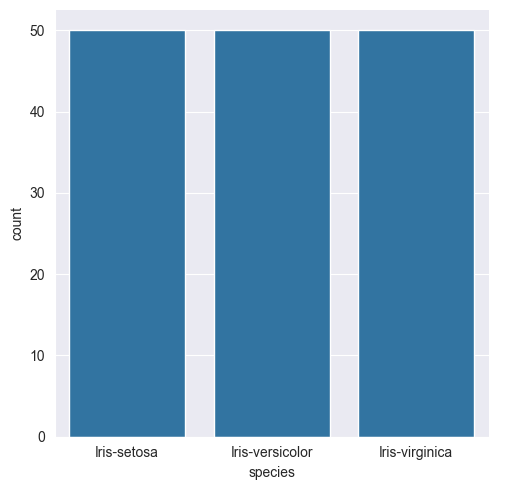

In [8]:
catplot = sns.catplot(data=df, x='species', kind='count')

catplot.savefig(os.path.join(wdir, "class_count.png"))

Realizzazione di un PairPlot per avere un'idea delle relazioni che intercorrono tra le variabili, con l'aggiunta di un boxplot sulla diagonale per verificare la presenza di outliers

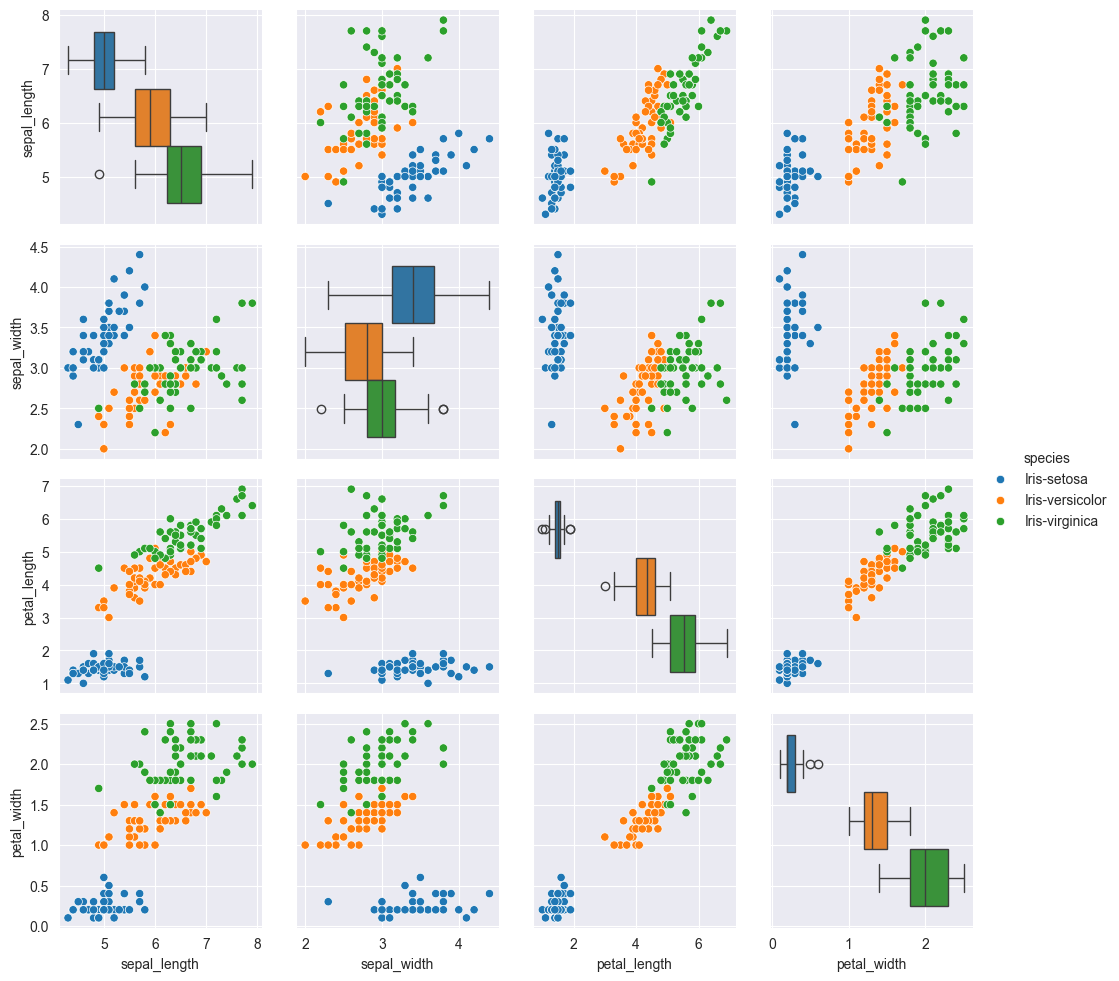

In [9]:
grid = sns.PairGrid(df, hue='species')
grid.map_diag(sns.boxplot)
grid.map_offdiag(sns.scatterplot)
grid.add_legend()
grid.savefig(os.path.join(wdir, "pairplot.png"))

Vi è una correlazione positiva tra le seguenti features:
* petal_lenght e sepal_length
* petal_width e sepal_length
* petal_width e petal_length

Si procede con un ulterirore analisi sui boxplots 

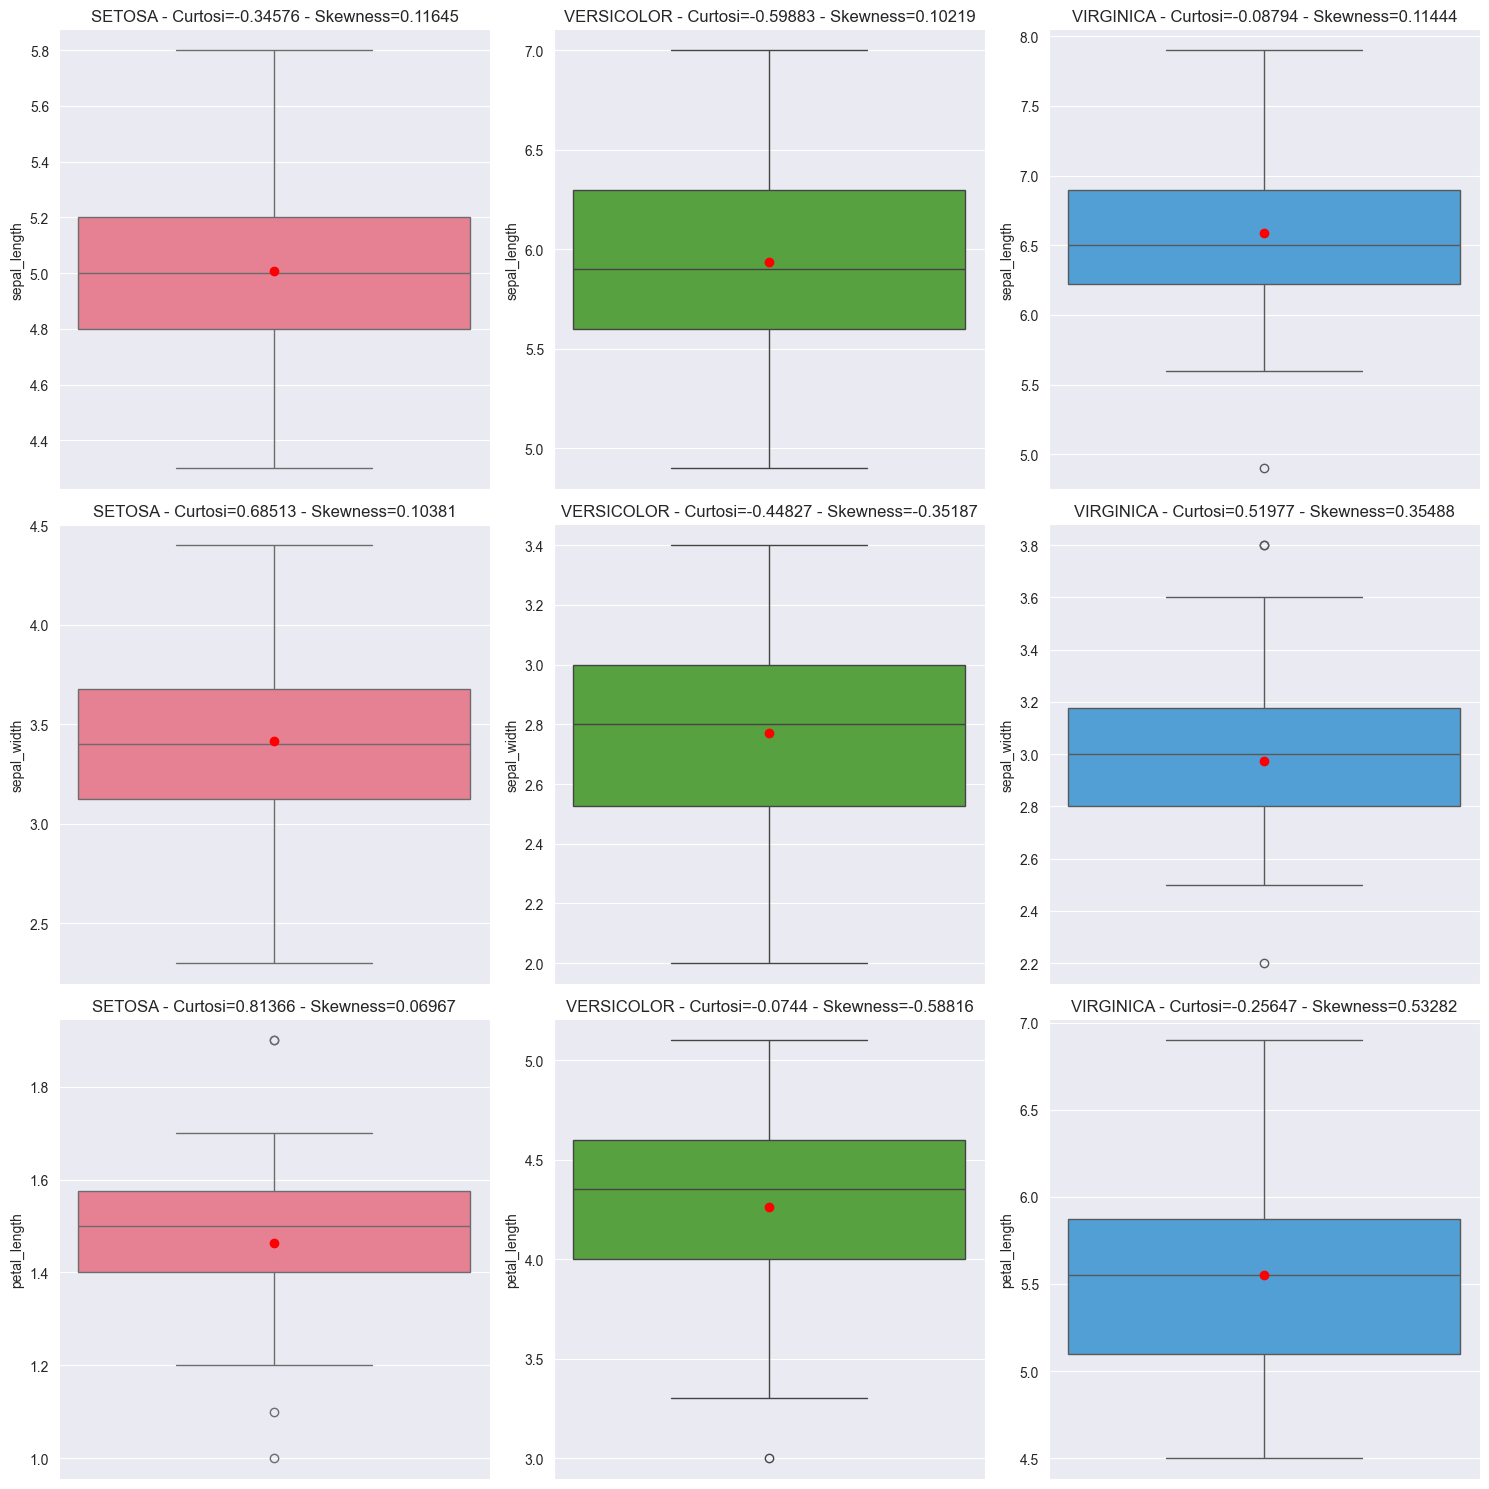

In [10]:
species = df['species'].unique()
features = df.columns[:-2]

# Creazione di una griglia 3x3
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
# Per ogni specie assegno un colore
col_colors = sns.color_palette("husl", n_colors=len(species))

# Creazione dei boxplot
for i, feature in enumerate(features):
    for j, specie in enumerate(species):
        current_data = df[df['species'] == specie]
        sns.boxplot(data=current_data, y=feature,ax=axes[i, j], color=col_colors[j])
        axes[i, j].set_title(f"{specie.replace('Iris-', '').upper()} - Curtosi={round(st.describe(current_data[feature]).kurtosis, 5)} - Skewness={round(st.describe(current_data[feature]).skewness, 5)}")
    
        # Aggiungo un punto di riferiemnto per la media
        axes[i, j].scatter(0, current_data[feature].mean(), color='red', zorder=3)


# Aggiusta lo spaziamento tra i subplot
plt.tight_layout()
fig.savefig(os.path.join(wdir, "boxplots.png"))

Nel complesso le distribuzioni mostrano un andamento pressocché normale senza forti asimmetrie. Si nota la presenza di probabili outliers in alcuni boxplots. Per completezza si riportano i relativi istogrammi

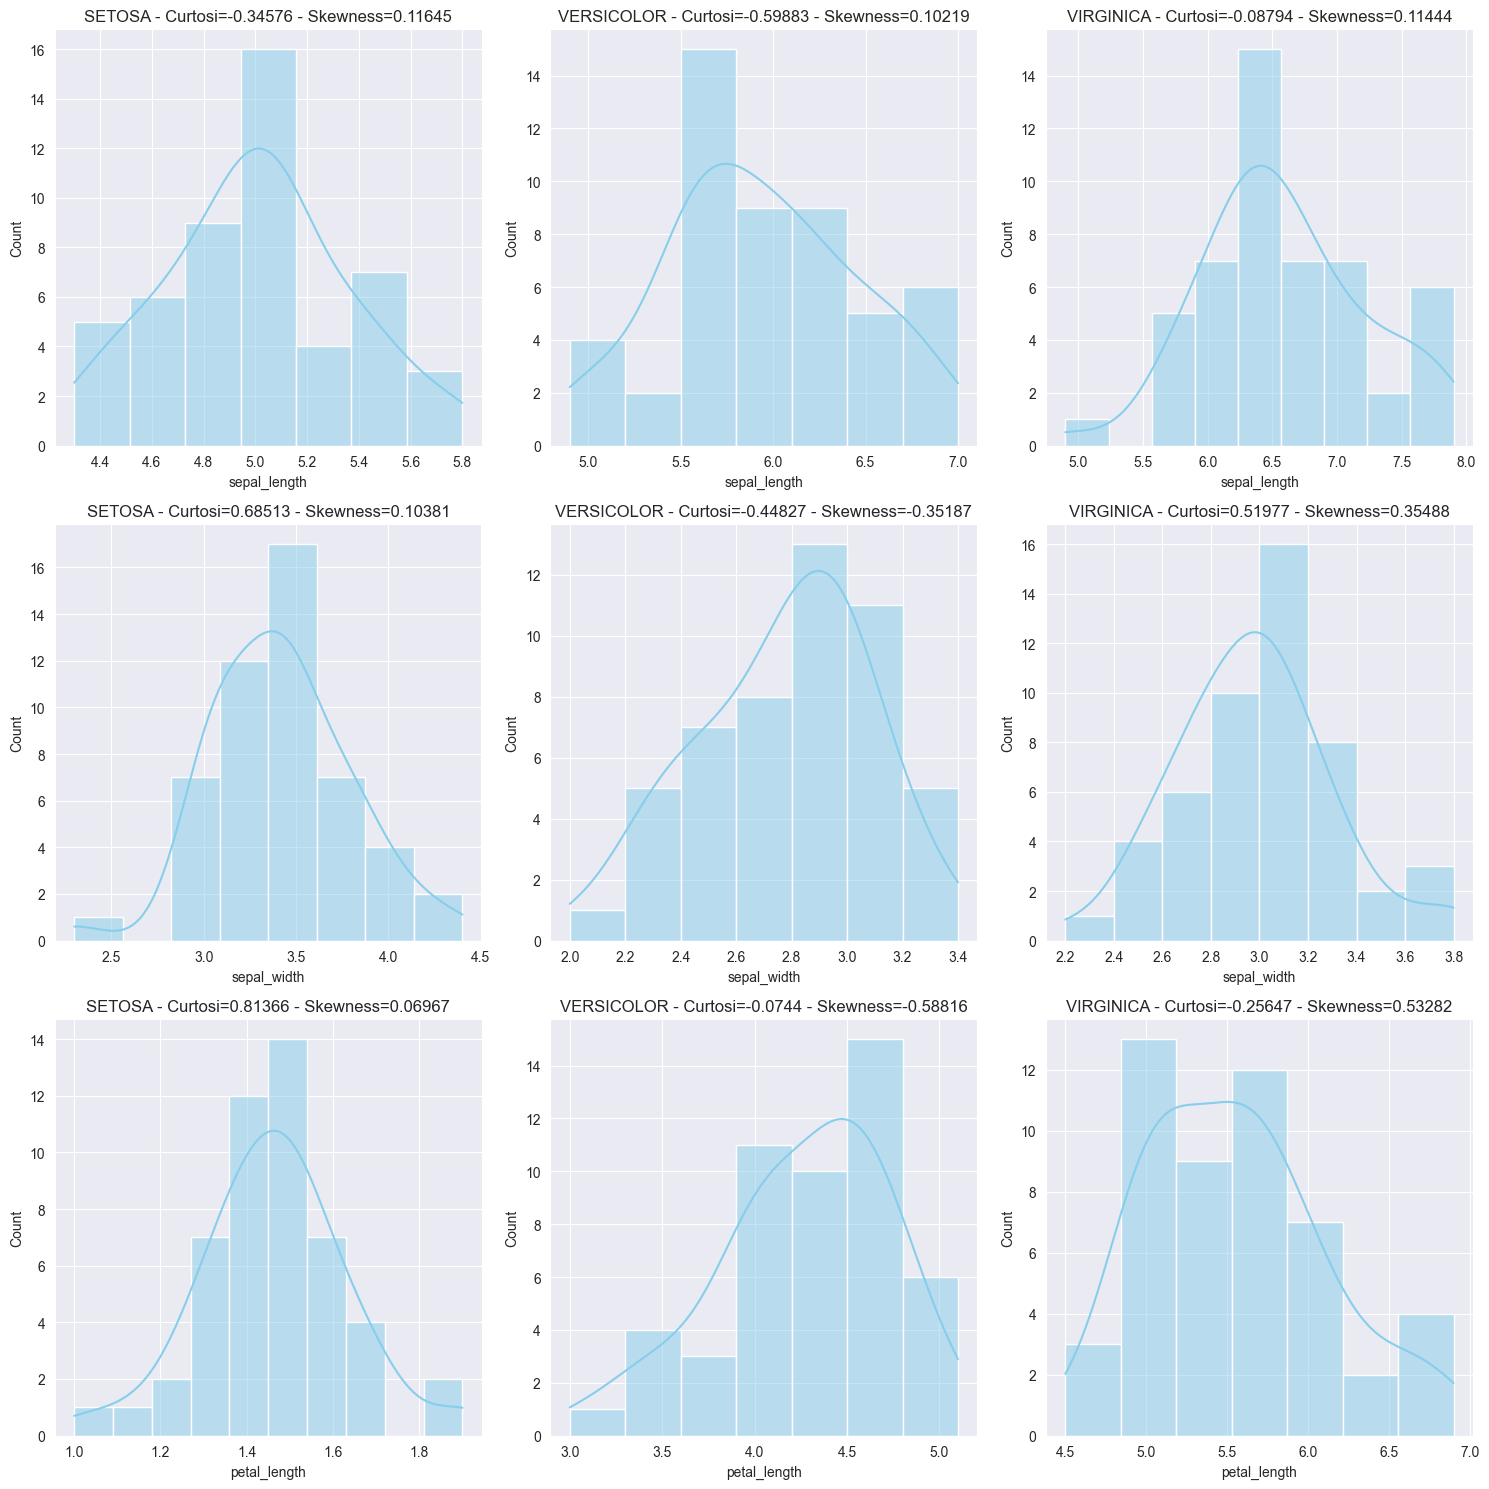

In [11]:
species = df['species'].unique()
features = df.columns[:-2]

# Creazione di una griglia 3x3
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
# Per ogni specie assegno un colore
col_colors = sns.color_palette("husl", n_colors=len(species))

for i, feature in enumerate(features):
    for j, specie in enumerate(species):
        current_data = df[df['species'] == specie]
        sns.histplot(data=current_data, x=feature, ax=axes[i, j], color='skyblue', kde=True) # kde mette in sovraimpressione la curva
        axes[i, j].set_title(f'{feature} vs {specie}')
        axes[i, j].set_title(f"{specie.replace('Iris-', '').upper()} - Curtosi={round(st.describe(current_data[feature]).kurtosis, 5)} - Skewness={round(st.describe(current_data[feature]).skewness, 5)}")

# Aggiusta lo spaziamento tra i subplot
plt.tight_layout()
fig.savefig(os.path.join(wdir, "histos.png"))

#### Correlation Matrix
---
Una misura quantitativa di quanto ciascuna variabile sia correlata ad un'altra si ottiene calcolando la matrice di correlazione. Di fatto si determina la covarianza tra ogni coppia di variabili e si crea una matrice per visualizzare comodamente ogni coppia. Tenendo conto che una buona correlazione si ha se l'entrata della matrice è in modulo pressocché pari ad 1. 

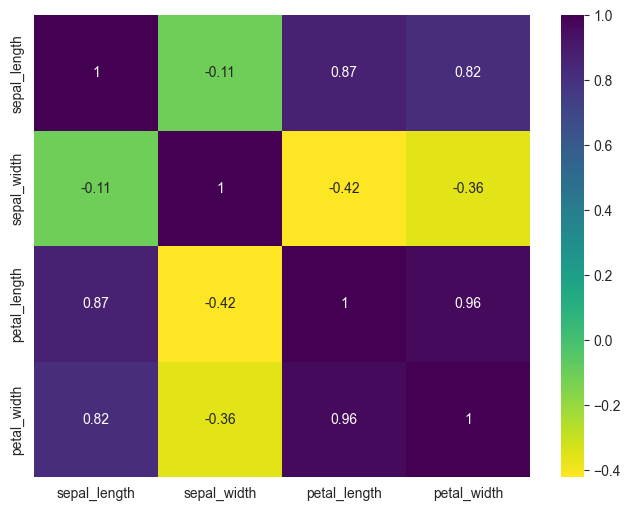

In [12]:
corr_matrix = df.drop(["species"], axis=1).corr()

plt.figure(figsize=(8, 6))
# Mappa di colori personalizzata
sns.heatmap(corr_matrix, annot=True, cmap='viridis_r')
plt.savefig(os.path.join(wdir, "corr_matrix.png"))

Si riconfermano le correlazioni tra le features notate nel Pairgrid. Per completezza si realizza un grafico in cui vengono rappresentate le tre rette di regressione

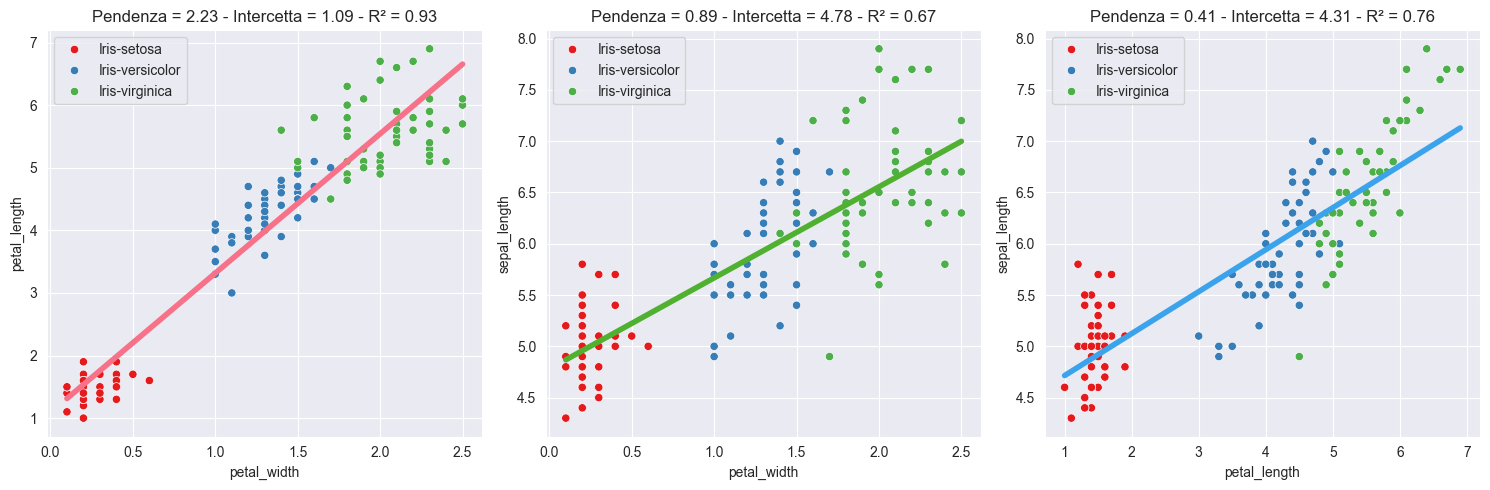

In [13]:
# Variabili da plottare
coupled_vars = [('petal_width', 'petal_length'), ('petal_width', 'sepal_length'), ('petal_length', 'sepal_length')]

# Griglia
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Colori per le rette di regressione
palette = sns.color_palette("husl", n_colors=len(coupled_vars))

# Rette di regressione
for i, (x_var, y_var) in enumerate(coupled_vars):
    # Punti colorati in base alla specie
    sns.scatterplot(x=x_var, y=y_var, hue='species', data=df, ax=axes[i], palette='Set1')
    
    # Retta di regressione con statsmodels
    X = sm.add_constant(df[x_var])
    linmod = sm.OLS(df[y_var], X)
    res = linmod.fit()
    slope = res.params[x_var]
    intercept = res.params['const']
    r_squared = res.rsquared
    
    # Plot della retta di regressione
    x_values = np.array([df[x_var].min(), df[x_var].max()]) # estraggo i due punti più estremi per tracciare la retta
    y_values = intercept + slope * x_values
    axes[i].plot(x_values, y_values, color=palette[i], linestyle='-', linewidth=4)
    
    # Titolo del grafico
    axes[i].set_title(f'Pendenza = {slope:.2f} - Intercetta = {intercept:.2f} - R² = {r_squared:.2f}')
    axes[i].legend()

plt.tight_layout()
fig.savefig(os.path.join(wdir, "regressione.png"))

Si osserva dunque una correlazione positiva per ogni coppia di variabili, con un R² pressocché pari ad 1. Si ricorda inoltre che la pendenza rappresenta la variazione media subita da Y quando X aumenta di un'unità

# Setup del modello
---

In [91]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.multiclass import OneVsOneClassifier

from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, precision_recall_curve

#### Pre-processing dei dati

In [105]:
# Shuffle dei dati in quanto sono separati per specie
df_shuffle = df.sample(frac=1)
# Split del dataset in train and test
df_no_target = df_shuffle.iloc[:, :-1]
target = df_shuffle.iloc[:, -1:]
X_train, X_test, y_train, y_test = train_test_split(df_no_target, target, test_size=0.2, random_state=30)
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

In [106]:
# Standardizzazione dei dati
X_train_standard = StandardScaler().fit_transform(X_train)
X_train_standard

array([[ 0.68456341, -0.57676005,  1.03852668,  1.1819095 ],
       [-1.50603949,  0.79375888, -1.34172547, -1.17536153],
       [-1.62773966, -1.71885915, -1.39839814, -1.17536153],
       [-0.53243821,  1.93585798, -1.17170746, -1.04440203],
       [-0.41073804, -1.71885915,  0.13176396,  0.13423349],
       [-0.41073804,  1.0221787 , -1.39839814, -1.30632103],
       [-0.53243821,  1.47901834, -1.2850528 , -1.30632103],
       [ 1.29306421,  0.33691924,  1.09519935,  1.44382851],
       [-1.01923885, -1.71885915, -0.26494473, -0.25864502],
       [-1.14093901,  0.10849941, -1.2850528 , -1.43728053],
       [-0.41073804, -1.03359969,  0.35845464,  0.00327399],
       [-0.28903788, -0.57676005,  0.64181799,  1.05095   ],
       [-0.28903788, -0.80517987,  0.2451093 ,  0.13423349],
       [-0.41073804, -1.49043933,  0.01841862, -0.12768551],
       [ 1.77986486, -0.34834023,  1.43523538,  0.789031  ],
       [-0.53243821,  1.93585798, -1.39839814, -1.04440203],
       [-1.01923885, -2.

I SVM non sono performanti per grandi dataset, non è questo il caso. Tuttavia la tecnica one-versus-the-rest è comunque da preferire in quanto l'addestramento di tanti classificatori su piccoli training set è più veloce rispetto ad addestrare tanti classificatori su training set più grandi. Anche se per la maggior parte dei classificatori binari la tecnica one-versus-the-rest è da preferire.

In [107]:
OvO_classifier = OneVsOneClassifier(SVC(kernel="poly", degree=3, coef0=1, C=5))

Un modo di valutare la bontà del modello rapidamente è la cross validation. Questo metodo estrae randomicamente 3 subsets diversi a partire dal training set, dopodichè addestra e valuta 10 modelli differenti in ognuno di questi subsets. Il risultato in questo caso è l'accuracy dei modelli in ognuno dei subsets.

In [108]:
cross_val_score(OvO_classifier, X_train_standard, y_train, cv=3, scoring='accuracy')

array([0.975, 0.9  , 0.925])

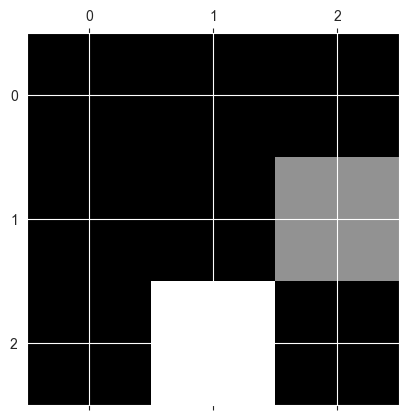

In [109]:
y_train_pred = cross_val_predict(OvO_classifier, X_train_standard, y_train, cv=3)
conf_matrix = confusion_matrix(y_train, y_train_pred)
# conf_matrix
# plt.matshow(conf_matrix, cmap=plt.cm.gray)
rows_sums = conf_matrix.sum(axis=1, keepdims=True)
norm_conf_matrix = conf_matrix / rows_sums
np.fill_diagonal(norm_conf_matrix, 0)
plt.matshow(norm_conf_matrix, cmap=plt.cm.gray)